# 머신러닝 (DecisionTree Regression)

In [1]:
import numpy as np
import pandas as pd 
from sqlalchemy import create_engine ,cast
# from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

from graphviz import Source
from sklearn import tree
from sklearn.tree import export_graphviz
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
#Source( tree.export_graphviz(dtreg, out_file=None, feature_names=X.columns))
# from sklearn import tree
# pip install graphviz
import graphviz

### 1. 분석데이터 로딩

In [3]:
#CSV 파일을 읽어 DataFrame 변수에 저장하기
featuresData = pd.read_csv("../dataset/feature_regression_example.csv")
featuresData.head()

,REGIONID,PRODUCTGROUP,PRODUCT,ITEM,YEARWEEK,YEAR,WEEK,QTY,HOLIDAY,HCLUS,PROMOTION,PRO_PERCENT
0,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201501,2015,1,1225,Y,1,Y,0.209442
1,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201502,2015,2,968,N,4,Y,0.209442
2,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201503,2015,3,1209,N,4,Y,0.208155
3,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201504,2015,4,1810,Y,2,Y,0.208155
4,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201505,2015,5,1773,N,4,Y,0.208155


### 2.데이터 형 변환

In [4]:
#형변환
featuresData[['WEEK','QTY','PRO_PERCENT']]=featuresData[['WEEK','QTY','PRO_PERCENT']].astype('float64')
featuresData.dtypes

REGIONID         object
PRODUCTGROUP     object
PRODUCT          object
ITEM             object
YEARWEEK          int64
YEAR              int64
WEEK            float64
QTY             float64
HOLIDAY          object
HCLUS             int64
PROMOTION        object
PRO_PERCENT     float64
dtype: object

### 3. 문자데이터 코드변환(Vector연산)

In [5]:
#case when 
############################
def codeConversion(df):
    if df == "Y":
        return 1
    else:
        return 0
    
############################       
    
featuresData['PROMOTIONCODE'] = featuresData['PROMOTION'].apply(codeConversion)
featuresData.head()

featuresData['HOLIDAYCODE'] = featuresData['HOLIDAY'].apply(codeConversion)
featuresData.head()

,REGIONID,PRODUCTGROUP,PRODUCT,ITEM,YEARWEEK,YEAR,WEEK,QTY,HOLIDAY,HCLUS,PROMOTION,PRO_PERCENT,PROMOTIONCODE,HOLIDAYCODE
0,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201501,2015,1.0,1225.0,Y,1,Y,0.209442,1,1
1,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201502,2015,2.0,968.0,N,4,Y,0.209442,1,0
2,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201503,2015,3.0,1209.0,N,4,Y,0.208155,1,0
3,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201504,2015,4.0,1810.0,Y,2,Y,0.208155,1,1
4,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201505,2015,5.0,1773.0,N,4,Y,0.208155,1,0


### 4. 데이터 셋 분리

In [6]:
predictStd = 201630

In [7]:
#where between and (조건 절)
trainingData = featuresData.query('YEARWEEK <= @predictStd')
trainingData.head()

,REGIONID,PRODUCTGROUP,PRODUCT,ITEM,YEARWEEK,YEAR,WEEK,QTY,HOLIDAY,HCLUS,PROMOTION,PRO_PERCENT,PROMOTIONCODE,HOLIDAYCODE
0,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201501,2015,1.0,1225.0,Y,1,Y,0.209442,1,1
1,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201502,2015,2.0,968.0,N,4,Y,0.209442,1,0
2,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201503,2015,3.0,1209.0,N,4,Y,0.208155,1,0
3,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201504,2015,4.0,1810.0,Y,2,Y,0.208155,1,1
4,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201505,2015,5.0,1773.0,N,4,Y,0.208155,1,0


In [8]:
trainingData.shape

(83, 14)

In [9]:
#where between and (조건 절)
testData = featuresData.query('YEARWEEK > @predictStd')
testData.head()

,REGIONID,PRODUCTGROUP,PRODUCT,ITEM,YEARWEEK,YEAR,WEEK,QTY,HOLIDAY,HCLUS,PROMOTION,PRO_PERCENT,PROMOTIONCODE,HOLIDAYCODE
83,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201631,2016,31.0,1522.0,N,4,Y,0.280258,1,0
84,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201632,2016,32.0,2100.0,N,4,Y,0.280258,1,0
85,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201633,2016,33.0,43.0,N,4,N,0.000000,0,0
86,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201634,2016,34.0,1700.0,Y,1,Y,0.308584,1,1
87,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201635,2016,35.0,1514.0,Y,1,Y,0.308584,1,1


In [10]:
trainingData_feature = trainingData[['PRO_PERCENT','HOLIDAYCODE']]

In [11]:
trainingData_label = trainingData[['QTY']]

In [12]:
testData_feature = testData[['PRO_PERCENT','HOLIDAYCODE']]

In [13]:
testData_label = testData[['QTY']]

### 5. 모델선언 및 예측 (Linear Regression)


In [14]:
from sklearn import datasets, linear_model

In [15]:
#lm = linear_model.LinearRegression()
#model = lm.fit(trainingData_feature, trainingData_label)
#predictions = lm.predict(testData_feature)

In [16]:
model_method= tree.DecisionTreeClassifier()
model = model_method.fit(trainingData_feature, trainingData_label)
predictions = model_method.predict(testData_feature)

### 6. 데이터 정리

In [17]:
predictData = pd.DataFrame(predictions)

In [18]:
predictData.columns = ["PREDICT"]

In [19]:
testData.reset_index(drop=True, inplace=True)

In [20]:
predictData.reset_index(drop=True, inplace=True)

In [21]:
#testData_feature.reset_index(drop=True, inplace=True)

In [22]:
#cncatenate labels to df as a new column / column binding
finalDf = pd.concat([testData, predictData], axis = 1)

In [23]:
finalDf.head()

,REGIONID,PRODUCTGROUP,PRODUCT,ITEM,YEARWEEK,YEAR,WEEK,QTY,HOLIDAY,HCLUS,PROMOTION,PRO_PERCENT,PROMOTIONCODE,HOLIDAYCODE,PREDICT
0,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201631,2016,31.0,1522.0,N,4,Y,0.280258,1,0,973.0
1,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201632,2016,32.0,2100.0,N,4,Y,0.280258,1,0,973.0
2,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201633,2016,33.0,43.0,N,4,N,0.000000,0,0,16.0
3,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201634,2016,34.0,1700.0,Y,1,Y,0.308584,1,1,968.0
4,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201635,2016,35.0,1514.0,Y,1,Y,0.308584,1,1,968.0


### 7 상관관계 계수 측정

In [24]:
df_corr= finalDf[['WEEK','HOLIDAYCODE','PRO_PERCENT','QTY','PREDICT']]

In [25]:
corr = df_corr.corr(method='pearson')

In [26]:
corr

,WEEK,HOLIDAYCODE,PRO_PERCENT,QTY,PREDICT
WEEK,1.000000,0.311909,0.721089,0.475861,0.795985
HOLIDAYCODE,0.311909,1.000000,0.509577,0.288627,0.481620
PRO_PERCENT,0.721089,0.509577,1.000000,0.753792,0.920393
QTY,0.475861,0.288627,0.753792,1.000000,0.583914
PREDICT,0.795985,0.481620,0.920393,0.583914,1.000000


In [27]:
print(corr)

                 WEEK  HOLIDAYCODE  PRO_PERCENT       QTY   PREDICT
WEEK         1.000000     0.311909     0.721089  0.475861  0.795985
HOLIDAYCODE  0.311909     1.000000     0.509577  0.288627  0.481620
PRO_PERCENT  0.721089     0.509577     1.000000  0.753792  0.920393
QTY          0.475861     0.288627     0.753792  1.000000  0.583914
PREDICT      0.795985     0.481620     0.920393  0.583914  1.000000


### 8. 정확도 측정

In [28]:
mean_absolute_error(finalDf['QTY'], finalDf['PREDICT'])  

566.4583333333334

In [29]:
mean_squared_error(finalDf['QTY'], finalDf['PREDICT'])  

520706.4583333333

In [30]:
finalDf.to_csv("./linear_result_sun.csv")

### 시각화 처리

In [31]:
#바로 차트가 시현되도록 설정
%matplotlib inline

In [32]:
plt.figure(figsize=(25,5))

In [33]:
finalDf['WEEK'].index

RangeIndex(start=0, stop=24, step=1)

In [34]:
finalDf.head()

,REGIONID,PRODUCTGROUP,PRODUCT,ITEM,YEARWEEK,YEAR,WEEK,QTY,HOLIDAY,HCLUS,PROMOTION,PRO_PERCENT,PROMOTIONCODE,HOLIDAYCODE,PREDICT
0,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201631,2016,31.0,1522.0,N,4,Y,0.280258,1,0,973.0
1,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201632,2016,32.0,2100.0,N,4,Y,0.280258,1,0,973.0
2,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201633,2016,33.0,43.0,N,4,N,0.000000,0,0,16.0
3,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201634,2016,34.0,1700.0,Y,1,Y,0.308584,1,1,968.0
4,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201635,2016,35.0,1514.0,Y,1,Y,0.308584,1,1,968.0


In [35]:
finalDf.head()

,REGIONID,PRODUCTGROUP,PRODUCT,ITEM,YEARWEEK,YEAR,WEEK,QTY,HOLIDAY,HCLUS,PROMOTION,PRO_PERCENT,PROMOTIONCODE,HOLIDAYCODE,PREDICT
0,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201631,2016,31.0,1522.0,N,4,Y,0.280258,1,0,973.0
1,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201632,2016,32.0,2100.0,N,4,Y,0.280258,1,0,973.0
2,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201633,2016,33.0,43.0,N,4,N,0.000000,0,0,16.0
3,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201634,2016,34.0,1700.0,Y,1,Y,0.308584,1,1,968.0
4,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201635,2016,35.0,1514.0,Y,1,Y,0.308584,1,1,968.0


Text(0,0.5,'value')

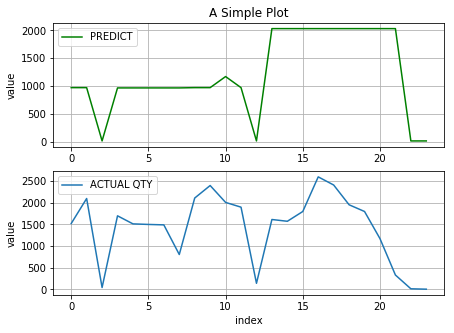

In [36]:
plt.figure(figsize=(7,5))
plt.subplot(211)
plt.plot(finalDf['WEEK'].index, finalDf['PREDICT'], "g", label='PREDICT')
plt.grid(True)
plt.legend(loc=0)
plt.ylabel('value')
plt.title('A Simple Plot')
plt.subplot(212)
plt.plot(finalDf['WEEK'].index,finalDf['QTY'],label='ACTUAL QTY')
plt.grid(True)
plt.legend(loc=0)
plt.xlabel('index')
plt.ylabel('value')

Text(0,0.5,'value 2nd')

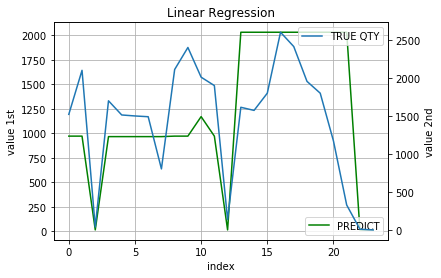

In [37]:
#첫번째 컬럼자료를 첫번째(왼쪽) 축에 대응하여 그림
fig, ax1 = plt.subplots()
plt.plot(finalDf['WEEK'].index, finalDf['PREDICT'],'g',label='PREDICT')
plt.grid(True)
plt.legend(loc=4)
plt.xlabel('index')
plt.ylabel('value 1st')
plt.title('Linear Regression')
#두번째 컬럼자료를 두번쨰(오른쪽) 축에 대응하여 그림
ax2 = ax1.twinx()
plt.plot(finalDf['WEEK'].index,finalDf['QTY'],label='TRUE QTY')
plt.legend(loc=0)
plt.ylabel('value 2nd')